In [142]:
import time
from IPython.display import display

notebook_start_time = time.perf_counter()
display("Notebook runtime: 0.00s", display_id="notebook_runtime")

'Notebook runtime: 12.05s'

<DisplayHandle display_id=notebook_runtime>

In [143]:
# Parameters
S0 = [100.0, 95.0, 110.0]
weights = [0.40, 0.35, 0.25]
mu_real = [0.06, 0.04, 0.05]
r = 0.02
sigma_base = [0.20, 0.25, 0.22]
base_rho = 0.35

T_base = 1.0 / 12.0
n_steps_per_year = 252
alpha_levels = [0.95, 0.99]

sigma_multipliers = [0.8, 1.0, 1.3, 1.6]
corr_rho_grid = [0.0, 0.5, 0.9]
horizon_grid = {"1w": 1.0 / 52.0, "1m": 1.0 / 12.0, "3m": 0.25}

n_paths_baseline = 20_000
n_paths_grid = [2_000, 5_000, 10_000, 20_000, 50_000]
seed_base = 7
seed_list = [11, 19, 23, 29, 31]

pnl_drift_mode = "real"  # "real" or "risk_neutral"

hist_alpha = 0.99
hist_bins = 60

run_vr_demo = True
vr_n_paths = 20_000
vr_seed_list = [101, 103, 107, 109, 113, 127]
vr_confidence = 0.95

pnl_mode = "linear"  # "linear" or "options"

option_book = [
    {"asset_idx": 0, "type": "call", "notional": 1.0, "strike_mult": 1.0},
    {"asset_idx": 1, "type": "put", "notional": 1.2, "strike_mult": 0.95},
    {"asset_idx": 2, "type": "call", "notional": 0.8, "strike_mult": 1.05},
]

In [144]:
import os
import sys

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.risk_metrics import (
    empirical_var,
    empirical_es,
    plot_pnl_histogram,
    simulate_portfolio_pnl,
)
from src.pricing import mc_european_call, mc_european_put
from src.payoffs import payoff_call, payoff_put
from src.gbm import simulate_correlated_gbm_paths

In [146]:
figures_dir = os.path.join(parent_dir, "figures", "11_tail_risk_and_stress")
os.makedirs(figures_dir, exist_ok=True)

sns.set_theme(style="whitegrid")
np.set_printoptions(precision=6, suppress=True)
pd.set_option("display.max_columns", 20)

# 11 Tail Risk and Stress

This notebook builds a **toy, end-to-end HF/Risk stress-testing workflow** for a multi-asset portfolio
using the existing GBM simulation and tail risk metrics (VaR / ES).

**Navigation**
- Setup & baseline assumptions
- Scenario definitions + risk surface
- PnL generation (linear or options-at-horizon)
- Tail metrics + histograms
- Estimator stability vs paths
- Variance reduction (pricing stability)
- Interpretation

**What this is**
- A scenario-based Monte Carlo stress lens to understand tail amplification and estimator noise.

**What this is not**
- Not a backtest or production risk system.
- Not a model validation exercise.

**Model choice**
- Correlated GBM under either real-world drift (PnL view) or risk-neutral drift (pricing view).
- VaR / ES are empirical tail summaries of simulated PnL.

**Limitations**
- No jumps, stochastic vol, fat tails, or liquidity effects.
- Correlation shocks are static and stylized.

We keep **all estimator logic in `src/`** and use the notebook for orchestration, plots, and interpretation.


## 1) Setup & baseline assumptions
We define a small 3-asset portfolio and choose a horizon / discretization.
The drift choice is controlled by `pnl_drift_mode`.

**Notes**
- If `pnl_drift_mode="real"`, PnL reflects a real-world drift view.
- If `pnl_drift_mode="risk_neutral"`, drift is set to `r` to align with pricing logic.


In [147]:
S0 = np.array(S0, dtype=float)
weights = np.array(weights, dtype=float)
mu_real = np.array(mu_real, dtype=float)
sigma_base = np.array(sigma_base, dtype=float)

if pnl_drift_mode == "real":
    mu = mu_real
else:
    mu = np.full_like(mu_real, r)

d = S0.size


def equicorrelation(rho: float, d: int) -> np.ndarray:
    if rho < -1.0 / (d - 1) or rho > 1.0:
        raise ValueError("rho outside equicorrelation PSD bounds.")
    corr = np.full((d, d), rho, dtype=float)
    np.fill_diagonal(corr, 1.0)
    return corr


def steps_for_horizon(T: float, steps_per_year: int) -> int:
    return max(1, int(round(T * steps_per_year)))


corr_base = equicorrelation(base_rho, d)
n_steps_base = steps_for_horizon(T_base, n_steps_per_year)

## 2) Scenario definitions
We keep the scenario set small and interpretable: a few volatility shocks, correlation shocks,
and a longer horizon shock. Each scenario has a unique label and ID used for plots.

Below we also build a **risk surface** to visualize how tail risk changes across the
volatility–correlation grid at a fixed horizon.


In [148]:
scenarios = []


def add_scenario(scenario_id: str, label: str, sigma: np.ndarray, corr: np.ndarray, T: float):
    scenarios.append(
        {
            "id": scenario_id,
            "label": label,
            "sigma": sigma,
            "corr": corr,
            "T": float(T),
            "n_steps": steps_for_horizon(T, n_steps_per_year),
        }
    )


sigma_high_1 = sigma_multipliers[-2]
sigma_high_2 = sigma_multipliers[-1]
corr_low = corr_rho_grid[0]
corr_high = corr_rho_grid[-1]

add_scenario("base", "Baseline", sigma_base, corr_base, T_base)
add_scenario(
    "sigma_x1.3", f"Vol shock x{sigma_high_1:.1f}", sigma_base * sigma_high_1, corr_base, T_base
)
add_scenario(
    "sigma_x1.6", f"Vol shock x{sigma_high_2:.1f}", sigma_base * sigma_high_2, corr_base, T_base
)
add_scenario(
    "corr_rho_0.0",
    f"Corr shock rho={corr_low:.1f}",
    sigma_base,
    equicorrelation(corr_low, d),
    T_base,
)
add_scenario(
    "corr_rho_0.9",
    f"Corr shock rho={corr_high:.1f}",
    sigma_base,
    equicorrelation(corr_high, d),
    T_base,
)
add_scenario("horizon_3m", "Horizon shock 3m", sigma_base, corr_base, horizon_grid["3m"])

scenario_df = pd.DataFrame(
    [
        {
            "scenario_id": sc["id"],
            "label": sc["label"],
            "T": sc["T"],
            "n_steps": sc["n_steps"],
            "sigma_mean": float(np.mean(sc["sigma"])),
            "corr_mean": float((np.sum(sc["corr"]) - d) / (d * (d - 1))),
        }
        for sc in scenarios
    ]
)
scenario_df

,scenario_id,label,T,n_steps,sigma_mean,corr_mean
0,base,Baseline,0.083333,21,0.223333,0.35
1,sigma_x1.3,Vol shock x1.3,0.083333,21,0.290333,0.35
2,sigma_x1.6,Vol shock x1.6,0.083333,21,0.357333,0.35
3,corr_rho_0.0,Corr shock rho=0.0,0.083333,21,0.223333,0.00
4,corr_rho_0.9,Corr shock rho=0.9,0.083333,21,0.223333,0.90
5,horizon_3m,Horizon shock 3m,0.250000,63,0.223333,0.35


## 3) PnL generation
We support two PnL definitions:

- **Option A (linear portfolio)**: `PnL = weights · S_T - weights · S_0`.
- **Option B (options book, maturity = horizon)**: pathwise discounted payoff minus MC price at t=0.

Set `pnl_mode` in the parameter cell. Option B is intentionally simple: options are European
and **mature at the risk horizon** to avoid nested repricing.


In [149]:
def option_book_pnl(
    S_T: np.ndarray,
    S0: np.ndarray,
    T: float,
    r: float,
    sigma: np.ndarray,
    option_book: list[dict],
    n_paths: int,
    seed: int,
    variance_reduction: str = "none",
) -> tuple[np.ndarray, float]:
    payoffs = np.zeros(S_T.shape[0], dtype=float)
    price0_total = 0.0
    for opt in option_book:
        idx = int(opt["asset_idx"])
        opt_type = opt["type"].lower()
        notional = float(opt["notional"])
        strike = float(S0[idx] * opt["strike_mult"])
        if opt_type == "call":
            payoff = payoff_call(S_T[:, idx], strike)
            price0 = mc_european_call(
                S0=S0[idx],
                K=strike,
                T=T,
                r=r,
                sigma=float(sigma[idx]),
                n_steps=1,
                n_paths=n_paths,
                seed=seed,
                variance_reduction=variance_reduction,
                return_details=False,
            )
        elif opt_type == "put":
            payoff = payoff_put(S_T[:, idx], strike)
            price0 = mc_european_put(
                S0=S0[idx],
                K=strike,
                T=T,
                r=r,
                sigma=float(sigma[idx]),
                n_steps=1,
                n_paths=n_paths,
                seed=seed,
                variance_reduction=variance_reduction,
                return_details=False,
            )
        else:
            raise ValueError(f"Unknown option type: {opt_type}")
        payoffs += notional * payoff
        price0_total += notional * price0
    pnl = np.exp(-r * T) * payoffs - price0_total
    return pnl, price0_total


pnl_by_scenario = {}
price0_by_scenario = {}

for sc in scenarios:
    if pnl_mode == "linear":
        pnl = simulate_portfolio_pnl(
            S0=S0,
            mu=mu,
            sigma=sc["sigma"],
            corr_matrix=sc["corr"],
            weights=weights,
            T=sc["T"],
            n_steps=sc["n_steps"],
            n_paths=n_paths_baseline,
            seed=seed_base,
        )
        pnl_by_scenario[sc["id"]] = pnl
    else:
        _, paths = simulate_correlated_gbm_paths(
            S0=S0,
            mu=mu,
            sigma=sc["sigma"],
            corr_matrix=sc["corr"],
            T=sc["T"],
            n_steps=sc["n_steps"],
            n_paths=n_paths_baseline,
            seed=seed_base,
        )
        S_T = paths[:, -1, :]
        pnl, price0 = option_book_pnl(
            S_T=S_T,
            S0=S0,
            T=sc["T"],
            r=r,
            sigma=sc["sigma"],
            option_book=option_book,
            n_paths=n_paths_baseline,
            seed=seed_base,
        )
        pnl_by_scenario[sc["id"]] = pnl
        price0_by_scenario[sc["id"]] = price0

summary_records = []
for sc in scenarios:
    pnl = pnl_by_scenario[sc["id"]]
    for alpha in alpha_levels:
        summary_records.append(
            {
                "scenario_id": sc["id"],
                "scenario_label": sc["label"],
                "alpha": alpha,
                "VaR": empirical_var(pnl, alpha=alpha),
                "ES": empirical_es(pnl, alpha=alpha),
                "mean_pnl": float(np.mean(pnl)),
                "std_pnl": float(np.std(pnl, ddof=1)),
                "n_paths": n_paths_baseline,
                "seed": seed_base,
            }
        )

summary_df = pd.DataFrame(summary_records)
summary_df

,scenario_id,scenario_label,alpha,VaR,ES,mean_pnl,std_pnl,n_paths,seed
0,base,Baseline,0.95,7.412531,9.304716,0.419463,4.892642,20000,7
1,base,Baseline,0.99,10.499110,11.914116,0.419463,4.892642,20000,7
2,sigma_x1.3,Vol shock x1.3,0.95,9.684853,12.071064,0.417405,6.362332,20000,7
3,sigma_x1.3,Vol shock x1.3,0.99,13.583826,15.350843,0.417405,6.362332,20000,7
4,sigma_x1.6,Vol shock x1.6,0.95,11.918597,14.769271,0.415329,7.833947,20000,7
5,sigma_x1.6,Vol shock x1.6,0.99,16.575950,18.671180,0.415329,7.833947,20000,7
6,corr_rho_0.0,Corr shock rho=0.0,0.95,5.739813,7.191131,0.415850,3.794617,20000,7
7,corr_rho_0.0,Corr shock rho=0.0,0.99,8.051779,9.242668,0.415850,3.794617,20000,7
8,corr_rho_0.9,Corr shock rho=0.9,0.95,9.551652,11.907945,0.417431,6.267622,20000,7
9,corr_rho_0.9,Corr shock rho=0.9,0.99,13.392277,15.112919,0.417431,6.267622,20000,7


## 2b) Scenario risk surface (sigma vs correlation)\n
We visualize ES at a fixed horizon across a grid of volatility multipliers and correlation levels.\n

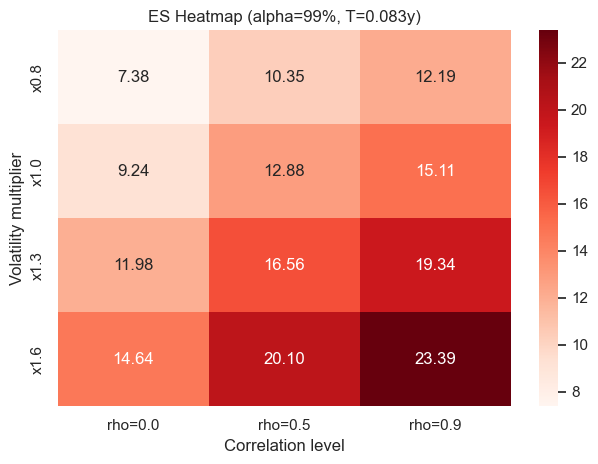

In [150]:
heatmap_alpha = 0.99
heatmap_T = T_base
heatmap_steps = steps_for_horizon(heatmap_T, n_steps_per_year)

heatmap_values = np.zeros((len(sigma_multipliers), len(corr_rho_grid)), dtype=float)

for i, sigma_mult in enumerate(sigma_multipliers):
    sigma = sigma_base * sigma_mult
    for j, rho in enumerate(corr_rho_grid):
        corr = equicorrelation(rho, d)
        if pnl_mode == "linear":
            pnl = simulate_portfolio_pnl(
                S0=S0,
                mu=mu,
                sigma=sigma,
                corr_matrix=corr,
                weights=weights,
                T=heatmap_T,
                n_steps=heatmap_steps,
                n_paths=n_paths_baseline,
                seed=seed_base,
            )
        else:
            _, paths = simulate_correlated_gbm_paths(
                S0=S0,
                mu=mu,
                sigma=sigma,
                corr_matrix=corr,
                T=heatmap_T,
                n_steps=heatmap_steps,
                n_paths=n_paths_baseline,
                seed=seed_base,
            )
            S_T = paths[:, -1, :]
            pnl, _ = option_book_pnl(
                S_T=S_T,
                S0=S0,
                T=heatmap_T,
                r=r,
                sigma=sigma,
                option_book=option_book,
                n_paths=n_paths_baseline,
                seed=seed_base,
            )
        heatmap_values[i, j] = empirical_es(pnl, alpha=heatmap_alpha)

heatmap_df = pd.DataFrame(
    heatmap_values,
    index=[f"x{m:.1f}" for m in sigma_multipliers],
    columns=[f"rho={r:.1f}" for r in corr_rho_grid],
)

fig, ax = plt.subplots(figsize=(6.5, 4.8))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Reds", ax=ax)
ax.set_xlabel("Correlation level")
ax.set_ylabel("Volatility multiplier")
ax.set_title(f"ES Heatmap (alpha={heatmap_alpha:.0%}, T={heatmap_T:.3f}y)")
fig.tight_layout()
fig.savefig(os.path.join(figures_dir, "es_heatmap_sigma_vs_corr.png"), dpi=150)
plt.show()
plt.close(fig)

At this point we have scenario-level PnL samples and summary tail metrics.
Next we visualize the distributions and then stress the estimators themselves.


## 4) Tail risk metrics + PnL histograms
We plot the baseline and a small number of stress scenarios to avoid clutter.
VaR/ES values for **both** alpha levels are computed in the table above.

Interpretation tip: focus on **relative shifts** in the left tail rather than the center mass.


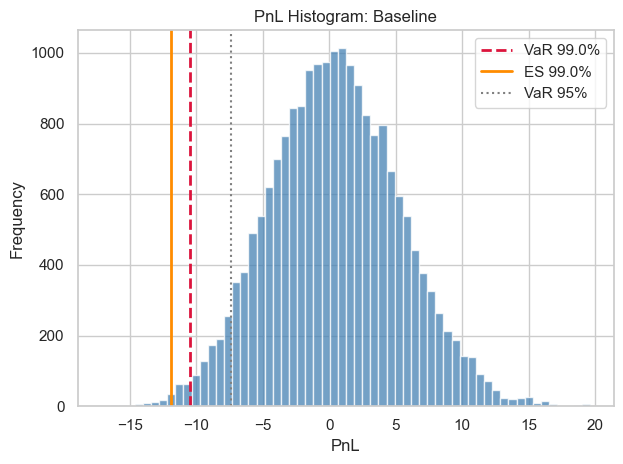

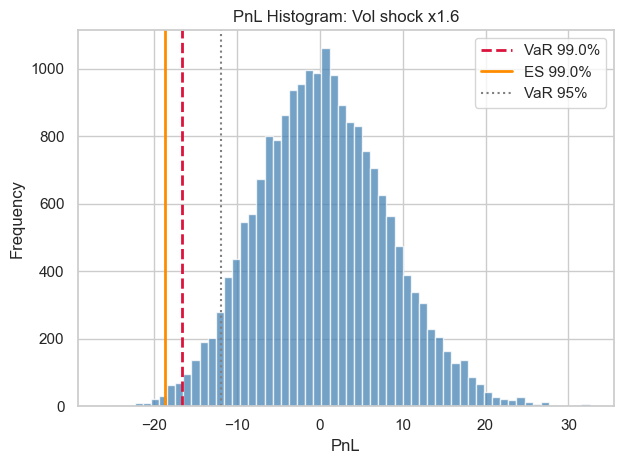

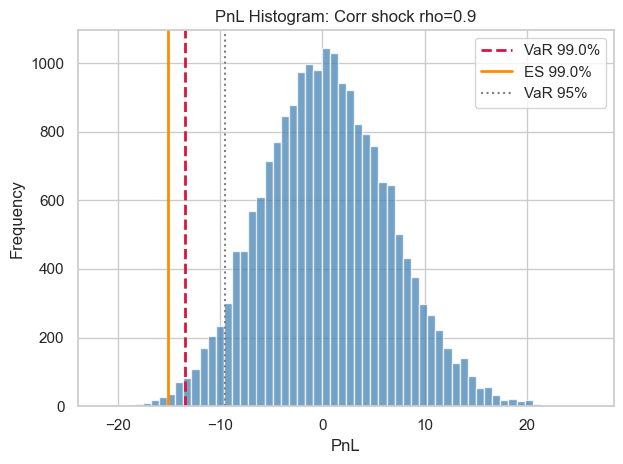

In [151]:
plot_scenarios = ["base", "sigma_x1.6", "corr_rho_0.9"]

for sc in scenarios:
    if sc["id"] not in plot_scenarios:
        continue
    pnl = pnl_by_scenario[sc["id"]]

    var_95 = empirical_var(pnl, alpha=0.95)
    es_95 = empirical_es(pnl, alpha=0.95)
    var_99 = empirical_var(pnl, alpha=0.99)
    es_99 = empirical_es(pnl, alpha=0.99)

    fig, ax = plot_pnl_histogram(
        pnl,
        alpha=hist_alpha,
        var=var_99,
        es=es_99,
        bins=hist_bins,
    )
    ax.axvline(-var_95, color="gray", linestyle=":", linewidth=1.5, label="VaR 95%")
    ax.set_title(f"PnL Histogram: {sc['label']}")
    ax.legend()

    if sc["id"] == "base":
        out_name = "pnl_hist_baseline.png"
    else:
        out_name = f"pnl_hist_scenario_{sc['id']}.png"

    fig.tight_layout()
    fig.savefig(os.path.join(figures_dir, out_name), dpi=150)
    plt.show()
    plt.close(fig)

A quick tail amplification check (relative to baseline):

- Ratios above 1 indicate tail amplification versus the baseline scenario.


In [152]:
baseline_es_99 = summary_df.query("scenario_id == 'base' and alpha == 0.99")["ES"].iloc[0]
amplification_df = summary_df[summary_df["alpha"] == 0.99].copy()
amplification_df["ES_vs_base"] = amplification_df["ES"] / baseline_es_99
amplification_df[["scenario_label", "ES", "ES_vs_base"]]

,scenario_label,ES,ES_vs_base
1,Baseline,11.914116,1.000000
3,Vol shock x1.3,15.350843,1.288458
5,Vol shock x1.6,18.671180,1.567148
7,Corr shock rho=0.0,9.242668,0.775775
9,Corr shock rho=0.9,15.112919,1.268489
11,Horizon shock 3m,19.695252,1.653102


## 5) Estimation stability vs number of paths
We estimate VaR/ES across a grid of path counts and seeds, then plot mean and variability.

This isolates **estimation noise** from **scenario effects**.


In [153]:
stability_scenarios = ["base", "sigma_x1.6", "corr_rho_0.9"]

stability_records = []

for sc in scenarios:
    if sc["id"] not in stability_scenarios:
        continue
    for n_paths in n_paths_grid:
        for seed in seed_list:
            if pnl_mode == "linear":
                pnl = simulate_portfolio_pnl(
                    S0=S0,
                    mu=mu,
                    sigma=sc["sigma"],
                    corr_matrix=sc["corr"],
                    weights=weights,
                    T=sc["T"],
                    n_steps=sc["n_steps"],
                    n_paths=n_paths,
                    seed=seed,
                )
            else:
                _, paths = simulate_correlated_gbm_paths(
                    S0=S0,
                    mu=mu,
                    sigma=sc["sigma"],
                    corr_matrix=sc["corr"],
                    T=sc["T"],
                    n_steps=sc["n_steps"],
                    n_paths=n_paths,
                    seed=seed,
                )
                S_T = paths[:, -1, :]
                pnl, _ = option_book_pnl(
                    S_T=S_T,
                    S0=S0,
                    T=sc["T"],
                    r=r,
                    sigma=sc["sigma"],
                    option_book=option_book,
                    n_paths=n_paths,
                    seed=seed,
                )
            for alpha in alpha_levels:
                stability_records.append(
                    {
                        "scenario_id": sc["id"],
                        "scenario_label": sc["label"],
                        "alpha": alpha,
                        "VaR": empirical_var(pnl, alpha=alpha),
                        "ES": empirical_es(pnl, alpha=alpha),
                        "mean_pnl": float(np.mean(pnl)),
                        "std_pnl": float(np.std(pnl, ddof=1)),
                        "n_paths": n_paths,
                        "seed": seed,
                    }
                )

stability_df = pd.DataFrame(stability_records)
stability_df.head()

,scenario_id,scenario_label,alpha,VaR,ES,mean_pnl,std_pnl,n_paths,seed
0,base,Baseline,0.95,7.425667,9.368302,0.384191,4.850438,2000,11
1,base,Baseline,0.99,10.753069,12.309832,0.384191,4.850438,2000,11
2,base,Baseline,0.95,7.300795,9.003789,0.378342,4.772790,2000,19
3,base,Baseline,0.99,9.877730,11.568567,0.378342,4.772790,2000,19
4,base,Baseline,0.95,7.615457,9.539762,0.439207,4.989970,2000,23


In [154]:
agg_df = (
    stability_df.groupby(["scenario_id", "scenario_label", "alpha", "n_paths"])
    .agg("mean")
    .reset_index()
)
std_df = (
    stability_df.groupby(["scenario_id", "scenario_label", "alpha", "n_paths"])
    .agg("std")
    .reset_index()
)

agg_df.head()

,scenario_id,scenario_label,alpha,n_paths,VaR,ES,mean_pnl,std_pnl,seed
0,base,Baseline,0.95,2000,7.484158,9.334119,0.405069,4.899787,22.6
1,base,Baseline,0.95,5000,7.437168,9.270453,0.395128,4.902290,22.6
2,base,Baseline,0.95,10000,7.460262,9.330639,0.412252,4.935960,22.6
3,base,Baseline,0.95,20000,7.428394,9.284350,0.405586,4.912993,22.6
4,base,Baseline,0.95,50000,7.421600,9.278198,0.426569,4.906961,22.6


In [155]:
agg_with_std = agg_df.merge(
    std_df,
    on=["scenario_id", "scenario_label", "alpha", "n_paths"],
    suffixes=("_mean", "_std"),
)
agg_with_std[
    [
        "scenario_label",
        "alpha",
        "n_paths",
        "VaR_mean",
        "VaR_std",
        "ES_mean",
        "ES_std",
    ]
]

,scenario_label,alpha,n_paths,VaR_mean,VaR_std,ES_mean,ES_std
0,Baseline,0.95,2000,7.484158,0.156112,9.334119,0.202747
1,Baseline,0.95,5000,7.437168,0.189168,9.270453,0.143313
2,Baseline,0.95,10000,7.460262,0.090919,9.330639,0.104232
3,Baseline,0.95,20000,7.428394,0.062525,9.284350,0.072305
4,Baseline,0.95,50000,7.421600,0.032962,9.278198,0.042657
5,Baseline,0.99,2000,10.440612,0.403672,12.001680,0.354138
6,Baseline,0.99,5000,10.332727,0.105036,11.920859,0.278411
7,Baseline,0.99,10000,10.453474,0.097782,12.019692,0.120213
8,Baseline,0.99,20000,10.425132,0.079359,11.946292,0.111559
9,Baseline,0.99,50000,10.428088,0.037945,11.916701,0.104841


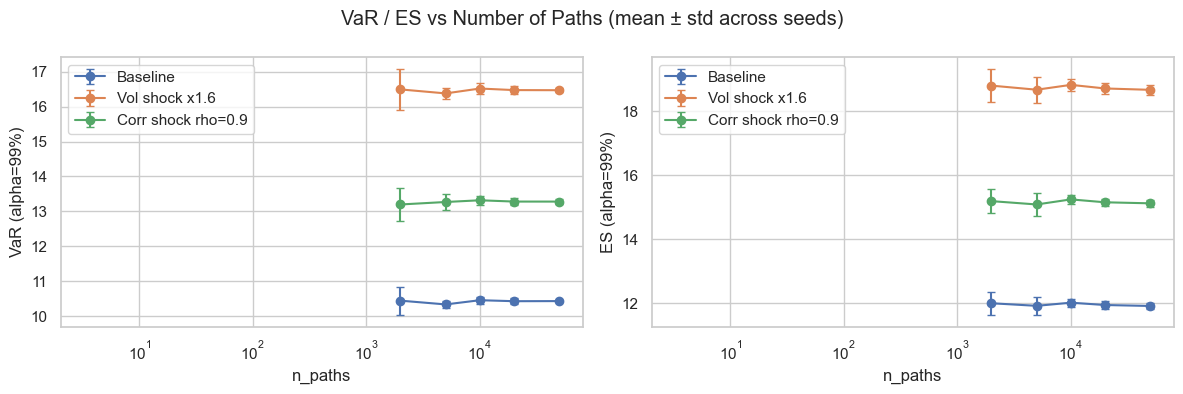

In [156]:
alpha_plot = 0.99

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
for metric, ax in zip(["VaR", "ES"], axes):
    for sc in scenarios:
        if sc["id"] not in stability_scenarios:
            continue
        mask = (agg_df["scenario_id"] == sc["id"]) & (agg_df["alpha"] == alpha_plot)
        std_mask = (std_df["scenario_id"] == sc["id"]) & (std_df["alpha"] == alpha_plot)
        x = agg_df.loc[mask, "n_paths"]
        y = agg_df.loc[mask, metric]
        yerr = std_df.loc[std_mask, metric]
        ax.errorbar(x, y, yerr=yerr, marker="o", capsize=3, label=sc["label"])
    ax.set_xscale("log")
    ax.set_xlabel("n_paths")
    ax.set_ylabel(f"{metric} (alpha={alpha_plot:.0%})")
    ax.legend()

fig.suptitle("VaR / ES vs Number of Paths (mean ± std across seeds)")
fig.tight_layout()
fig.savefig(os.path.join(figures_dir, "var_es_vs_paths.png"), dpi=150)
plt.show()
plt.close(fig)

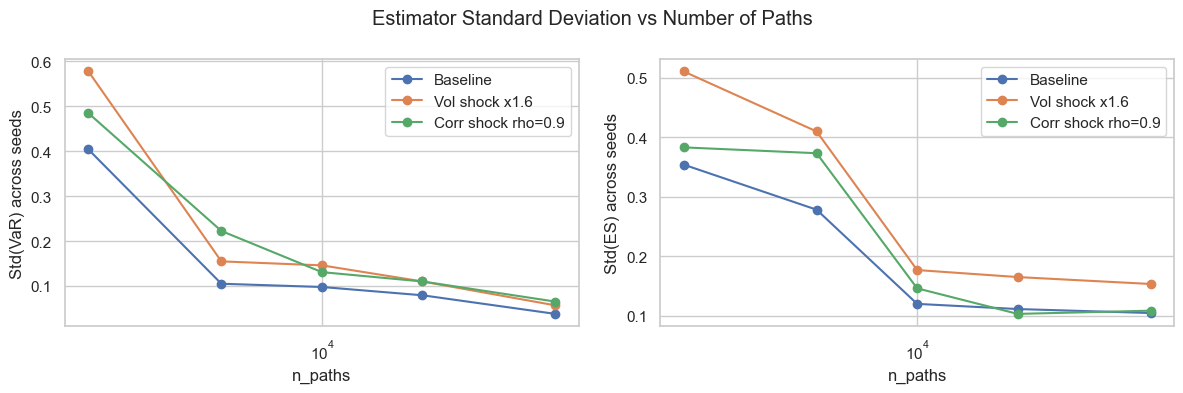

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
for metric, ax in zip(["VaR", "ES"], axes):
    for sc in scenarios:
        if sc["id"] not in stability_scenarios:
            continue
        mask = (std_df["scenario_id"] == sc["id"]) & (std_df["alpha"] == alpha_plot)
        x = std_df.loc[mask, "n_paths"]
        y = std_df.loc[mask, metric]
        ax.plot(x, y, marker="o", label=sc["label"])
    ax.set_xscale("log")
    ax.set_xlabel("n_paths")
    ax.set_ylabel(f"Std({metric}) across seeds")
    ax.legend()

fig.suptitle("Estimator Standard Deviation vs Number of Paths")
fig.tight_layout()
fig.savefig(os.path.join(figures_dir, "var_es_std_vs_paths.png"), dpi=150)
plt.show()
plt.close(fig)

## 6) Variance reduction impact (pricing stability)
We do **not** apply variance reduction to the linear PnL workflow.
Instead, we show a short, isolated pricing stability demo using the existing MC pricer.

This is a **pricing variance** illustration, not a direct tail-risk improvement claim.


mode   seed               price              stderr          
                     mean       std      mean       std      mean       std
0       antithetic  110.0  9.359487  7.487664  0.070575  0.063479  0.000773
1  control_variate  110.0  9.359487  7.501155  0.053293  0.036912  0.000265
2             none  110.0  9.359487  7.462102  0.085608  0.082678  0.001068

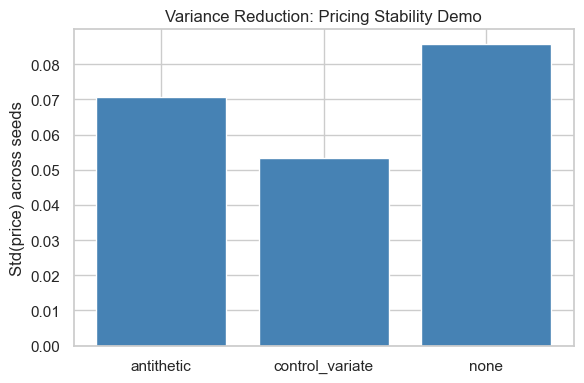

In [158]:
if run_vr_demo:
    vr_params = {
        "S0": 100.0,
        "K": 100.0,
        "T": 0.5,
        "r": r,
        "sigma": 0.25,
        "n_steps": 1,
        "n_paths": vr_n_paths,
    }

    vr_records = []
    for mode in ["none", "antithetic", "control_variate"]:
        for seed in vr_seed_list:
            result = mc_european_call(
                variance_reduction=mode,
                seed=seed,
                confidence=vr_confidence,
                return_details=True,
                **vr_params,
            )
            vr_records.append(
                {
                    "mode": mode,
                    "seed": seed,
                    "price": result.price,
                    "stderr": result.stderr,
                }
            )

    vr_df = pd.DataFrame(vr_records)
    vr_summary = vr_df.groupby("mode").agg(["mean", "std"]).reset_index()
    display(vr_summary)

    fig, ax = plt.subplots(figsize=(6, 4))
    std_by_mode = vr_df.groupby("mode")["price"].std()
    ax.bar(std_by_mode.index, std_by_mode.values, color="steelblue")
    ax.set_ylabel("Std(price) across seeds")
    ax.set_title("Variance Reduction: Pricing Stability Demo")
    fig.tight_layout()
    fig.savefig(os.path.join(figures_dir, "vr_effect_on_pricing.png"), dpi=150)
    plt.show()
    plt.close(fig)

## 7) Interpretation: tail amplification drivers
- **Volatility shocks** expand dispersion and create convex tail growth: ES grows faster than VaR.
- **Correlation shocks** cluster losses across assets, inflating tail risk even when mean PnL is flat.
- **Horizon shocks** amplify diffusion risk; longer horizons widen the tail nonlinearly.
- **Estimator uncertainty** is material at small `n_paths`: VaR/ES can move materially across seeds.

This is a **toy stress framework** and should be treated as an educational template only.


In [159]:
import time
from IPython.display import update_display

elapsed = time.perf_counter() - notebook_start_time
update_display(f"Notebook runtime: {elapsed:.2f}s", display_id="notebook_runtime")